In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn import preprocessing
from itertools import cycle
from itertools import chain
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import math

In [2]:
pd.options.display.float_format = '{:.1f}'.format
sns.set()
plt.style.use('ggplot')
print('Keras Version', keras.__version__)

LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
TIME_PERIOD = 80
WINDOW = 40
# originally used to fine tune the values, but that is now being done in a loop with several different dimension sizes.
tuner = 1

Keras Version 2.2.4-tf


In [3]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp','x-axis','y-axis','z-axis']
    df = pd.read_csv(file_path, header=None, names=column_names)

    df['z-axis'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    df['z-axis'] = df['z-axis'].apply(convert_to_float)

    df.dropna(axis=0,how='any',inplace=True)

    return df

In [4]:
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [5]:

def show_basic_dataframe(dataframe):
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i' % (dataframe.shape[0]))

In [6]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15,10), sharex=True)

    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

In [7]:
def plot_axis(ax,x,y,title):
    ax.plot(x,y,'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y)-np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

In [8]:
def create_segments_and_labels(df, time_steps, step, label_names):
    FEATURES = 3

    segments = []
    labels = []

    for i in range(0,len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        label = stats.mode(df[label_names][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203


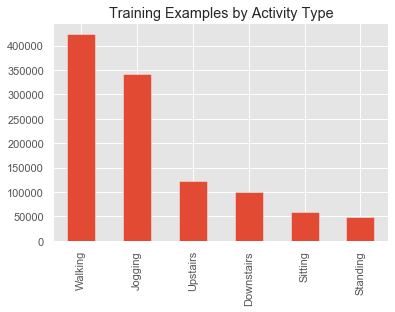

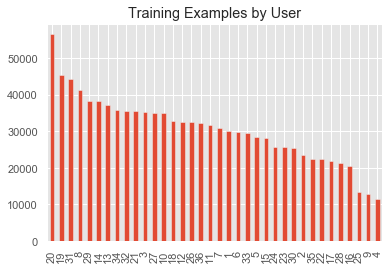

In [9]:

df = read_data('WISDM_ar_v1.1_raw.txt')
show_basic_dataframe(df)
df.head(20)

df['activity'].value_counts().plot(kind='bar', title='Training Examples by Activity Type')
plt.show()

df['user-id'].value_counts().plot(kind='bar',title='Training Examples by User')
plt.show()






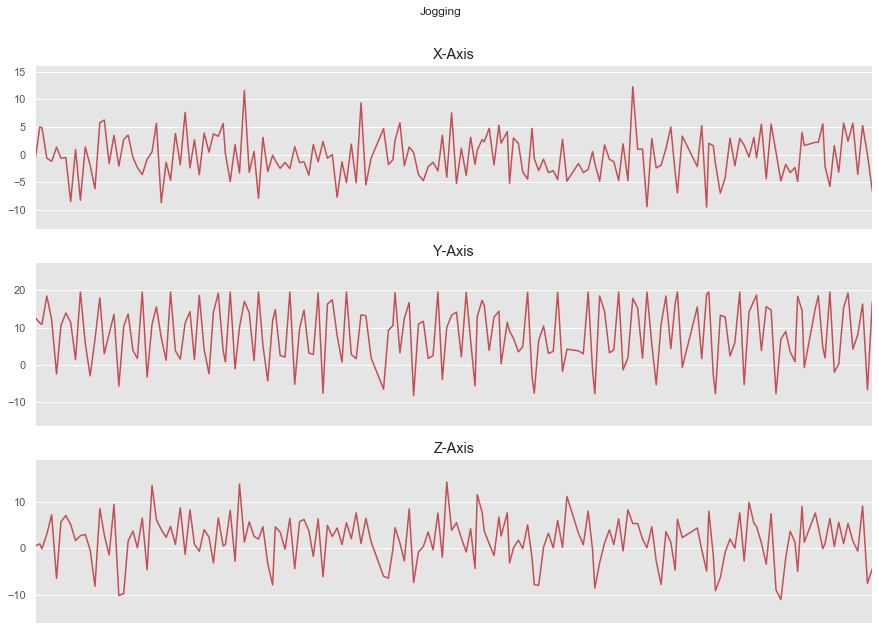

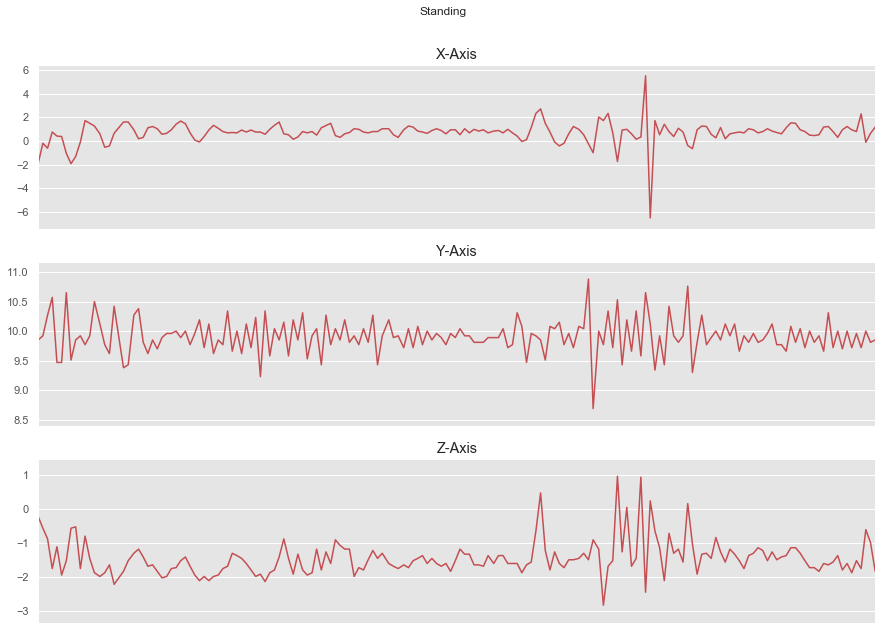

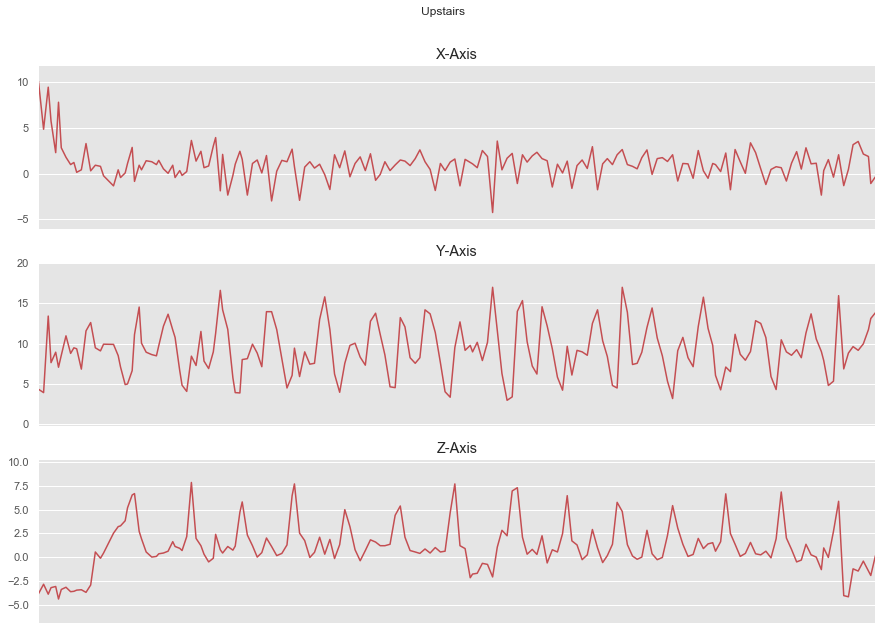

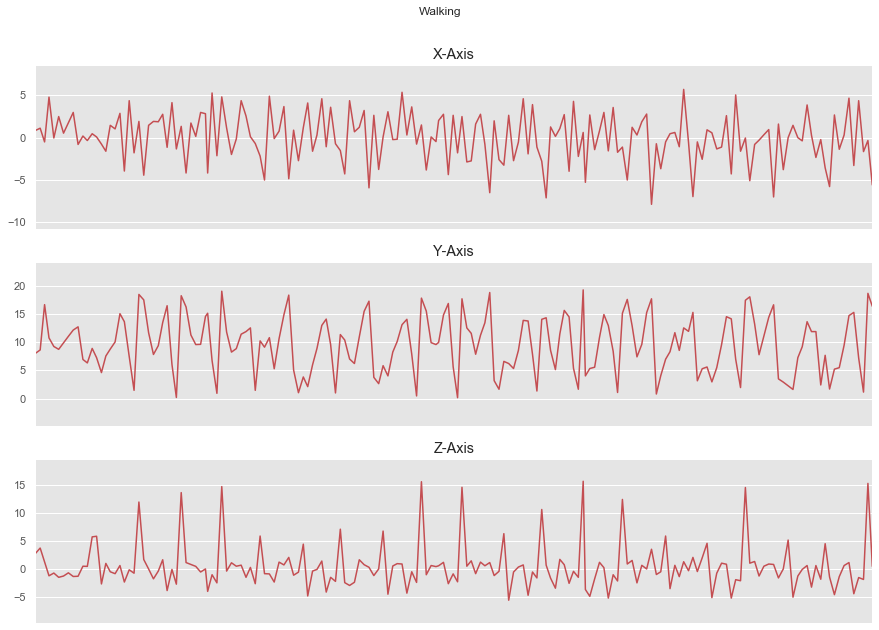

In [10]:
for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity,subset)

LABEL = 'ActivityEncoded'
le = preprocessing.LabelEncoder()

df[LABEL] = le.fit_transform(df['activity'].values.ravel())


In [11]:
    # Separate based of user id.
df_test = df[df['user-id'] > 28 ]
df_train = df[df['user-id'] <= 28 ]
df_train = df

pd.options.mode.chained_assignment = None
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

df_train = df_train.round({'x-axis': 4, 'y-axis':4, 'z-axis': 4})

X_train, y_train = create_segments_and_labels(df_train, TIME_PERIOD, WINDOW, LABEL)

print('X_train Shape:', X_train.shape)
print(X_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)
input_shape = (80*3)
x_train = X_train.reshape(X_train.shape[0], input_shape)
# print('x_train shape:', x_train)
print('input_shape:', input_shape)
samps, secs, accel = X_train.shape
red_dim = secs * accel

xx_train, xx_test, yy_train, yy_test = train_test_split(x_train, y_train, test_size = 0.2, random_state = 0, stratify = y_train)

print(xx_train.shape)
print(xx_test.shape)
X2_train = xx_train
X2_test = xx_test

X_train Shape: (27454, 80, 3)
27454 training samples
y_train shape:  (27454,)
input_shape: 240
(21963, 240)
(5491, 240)


In [12]:
num_time_periods, num_sensors = X_train.shape[1], X_train.shape[2]
num_classes = le.classes_.size
print(num_time_periods, num_sensors)
print(list(le.classes_))

80 3
['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


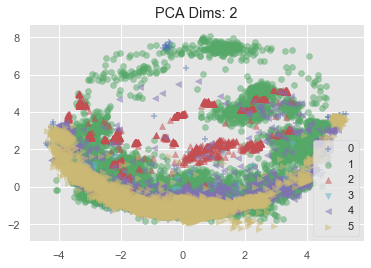

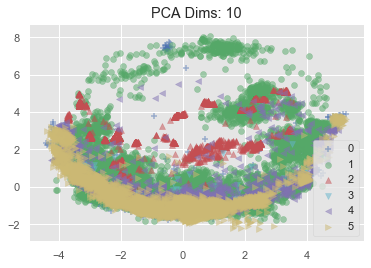

In [13]:
# Multiple PCA
components = [ 2, 5, 10, 20, 40, 80, 160, red_dim ]
accuracy = []
for j in components:
    #pca = PCA(n_components=red_dim-tuner)
    pca = PCA(n_components=j)

    X_train2d = X_train.reshape(-1, red_dim)
    # Use entire dataset.
    ds_pca = pca.fit_transform(X_train2d)
    ds_rec = pca.inverse_transform(ds_pca)

    colors = ['b','g','r','c','m','y','k']
    markers = ['+','o','^','v','<','>','D','h','s']

    for i, c, m in zip(np.unique(y_train), cycle(colors), cycle(markers)):
        plt.scatter(ds_pca[y_train==i, 0], ds_pca[y_train == i, 1],
                    c=c, marker=m, label=i, alpha=0.5)
        _ = plt.legend(loc='best')

    plt.title("PCA Dims: %d" % j)
    plt.show()

In [14]:
from sklearn.decomposition import PCA as RandomizedPCA
pca = RandomizedPCA(n_components=180)
pca.fit(x_train)

tX_train = pca.transform(x_train)


In [15]:
print(tX_train.shape)

(27454, 180)


In [16]:
from keras.utils import np_utils
input_shape = (num_time_periods*num_sensors)
tX_train = tX_train.reshape(tX_train.shape[0], 180)
print('x_train shape:', tX_train.shape)
print('input_shape:', 180)

x_train shape: (27454, 180)
input_shape: 180


Using TensorFlow backend.


In [17]:
tX_train = tX_train.astype('float32')
y_train = y_train.astype('float32')

In [18]:
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (27454, 6)


In [19]:

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [20]:
X_train, X_test, y_train, y_test = train_test_split(tX_train, y_train, test_size = 0.2, random_state = 0, stratify = y_train)


In [68]:

X_train.shape, X_test.shape
y_test.shape

(5491,)

In [22]:

X_train = X_train.reshape(21963, 60, 3, 1)
X_test = X_test.reshape(5491, 60, 3, 1)



In [23]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

In [24]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [25]:
history = model.fit(X_train, y_train, epochs = 100, validation_data= (X_test, y_test), verbose=1)


Train on 21963 samples, validate on 5491 samples
Epoch 1/100
21963/21963 [==============================] - 9s 388us/sample - loss: 0.6564 - accuracy: 0.7605 - val_loss: 0.4259 - val_accuracy: 0.8443
Epoch 2/100
21963/21963 [==============================] - 8s 347us/sample - loss: 0.4449 - accuracy: 0.8360 - val_loss: 0.3616 - val_accuracy: 0.8649
Epoch 3/100
21963/21963 [==============================] - 8s 382us/sample - loss: 0.4005 - accuracy: 0.8560 - val_loss: 0.3331 - val_accuracy: 0.8756
Epoch 4/100
21963/21963 [==============================] - 8s 354us/sample - loss: 0.3695 - accuracy: 0.8664 - val_loss: 0.3126 - val_accuracy: 0.8831
Epoch 5/100
21963/21963 [==============================] - 8s 352us/sample - loss: 0.3479 - accuracy: 0.8745 - val_loss: 0.3000 - val_accuracy: 0.8853
Epoch 6/100
21963/21963 [==============================] - 8s 359us/sample - loss: 0.3359 - accuracy: 0.8757 - val_loss: 0.2873 - val_accuracy: 0.8938
Epoch 7/100
21963/21963 [====================

21963/21963 [==============================] - 8s 387us/sample - loss: 0.1590 - accuracy: 0.9383 - val_loss: 0.2744 - val_accuracy: 0.9188
Epoch 55/100
21963/21963 [==============================] - 8s 349us/sample - loss: 0.1645 - accuracy: 0.9350 - val_loss: 0.2491 - val_accuracy: 0.9244
Epoch 56/100
21963/21963 [==============================] - 8s 377us/sample - loss: 0.1627 - accuracy: 0.9382 - val_loss: 0.2577 - val_accuracy: 0.9217
Epoch 57/100
21963/21963 [==============================] - 8s 356us/sample - loss: 0.1583 - accuracy: 0.9390 - val_loss: 0.2617 - val_accuracy: 0.9242
Epoch 58/100
21963/21963 [==============================] - 8s 365us/sample - loss: 0.1631 - accuracy: 0.9370 - val_loss: 0.2595 - val_accuracy: 0.9199
Epoch 59/100
21963/21963 [==============================] - 9s 403us/sample - loss: 0.1559 - accuracy: 0.9393 - val_loss: 0.2615 - val_accuracy: 0.9230
Epoch 60/100
21963/21963 [==============================] - 7s 338us/sample - loss: 0.1593 - accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


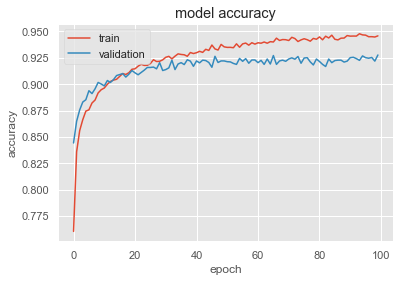

In [26]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [27]:
from tensorflow.keras.layers import Input, Dense
# from keras.models import Model


input_img = Input(shape=(240,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(240, activation='sigmoid')(decoded)

In [28]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Model
import os


log_dir = os.path.join('logs')
tensorboard_callback = TensorBoard(log_dir,profile_batch = 100000000)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(xx_train, xx_train,
                epochs=100,
                batch_size=64,
                shuffle=True,
                validation_data=(xx_test, xx_test),
                callbacks=[tensorboard_callback])

Train on 21963 samples, validate on 5491 samples
Epoch 1/100
21963/21963 [==============================] - 3s 133us/sample - loss: 0.0848 - val_loss: 0.0687
Epoch 2/100
21963/21963 [==============================] - 2s 94us/sample - loss: 0.0651 - val_loss: 0.0628
Epoch 3/100
21963/21963 [==============================] - 2s 94us/sample - loss: 0.0608 - val_loss: 0.0598
Epoch 4/100
21963/21963 [==============================] - 2s 91us/sample - loss: 0.0586 - val_loss: 0.0583
Epoch 5/100
21963/21963 [==============================] - 2s 93us/sample - loss: 0.0573 - val_loss: 0.0573
Epoch 6/100
21963/21963 [==============================] - 2s 90us/sample - loss: 0.0564 - val_loss: 0.0567
Epoch 7/100
21963/21963 [==============================] - 2s 96us/sample - loss: 0.0557 - val_loss: 0.0560
Epoch 8/100
21963/21963 [==============================] - 2s 100us/sample - loss: 0.0551 - val_loss: 0.0555
Epoch 9/100
21963/21963 [==============================] - 2s 97us/sample - loss: 0.0

21963/21963 [==============================] - 2s 89us/sample - loss: 0.0504 - val_loss: 0.0520
Epoch 76/100
21963/21963 [==============================] - 2s 91us/sample - loss: 0.0504 - val_loss: 0.0520
Epoch 77/100
21963/21963 [==============================] - 2s 90us/sample - loss: 0.0504 - val_loss: 0.0520
Epoch 78/100
21963/21963 [==============================] - 2s 90us/sample - loss: 0.0504 - val_loss: 0.0520
Epoch 79/100
21963/21963 [==============================] - 2s 85us/sample - loss: 0.0504 - val_loss: 0.0521
Epoch 80/100
21963/21963 [==============================] - 2s 90us/sample - loss: 0.0504 - val_loss: 0.0520
Epoch 81/100
21963/21963 [==============================] - 2s 90us/sample - loss: 0.0503 - val_loss: 0.0520
Epoch 82/100
21963/21963 [==============================] - 2s 92us/sample - loss: 0.0503 - val_loss: 0.0521
Epoch 83/100
21963/21963 [==============================] - 2s 85us/sample - loss: 0.0503 - val_loss: 0.0519
Epoch 84/100
21963/21963 [======

In [29]:
# !kill 6260
# %load_ext tensorboard

# %tensorboard --logdir logs  --host localhost 
print(xx_train.shape)

(21963, 240)


In [30]:
pred = autoencoder.predict(xx_train)

In [31]:
np.savetxt("lv.csv", pred, delimiter=",")
df11 = pd.read_csv("lv.csv",header=None)

In [32]:
X2_test.shape


(5491, 240)

In [33]:
X2_train = np.asarray(df11)

X2_train = X2_train.reshape(21963, 80, 3, 1)
X2_test = X2_test.reshape(5491, 80, 3, 1)

In [34]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X2_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

In [35]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [36]:
history = model.fit(X2_train, y_train, epochs = 100, validation_data= (X2_test, y_test), verbose=1)


Train on 21963 samples, validate on 5491 samples
Epoch 1/100
21963/21963 [==============================] - 10s 461us/sample - loss: 0.7662 - accuracy: 0.7208 - val_loss: 2.8216 - val_accuracy: 0.6584
Epoch 2/100
21963/21963 [==============================] - 9s 422us/sample - loss: 0.5822 - accuracy: 0.7875 - val_loss: 3.4210 - val_accuracy: 0.6545
Epoch 3/100
21963/21963 [==============================] - 9s 421us/sample - loss: 0.5375 - accuracy: 0.7994 - val_loss: 4.0196 - val_accuracy: 0.6507
Epoch 4/100
21963/21963 [==============================] - 9s 417us/sample - loss: 0.5163 - accuracy: 0.8086 - val_loss: 3.7884 - val_accuracy: 0.6895
Epoch 5/100
21963/21963 [==============================] - 9s 416us/sample - loss: 0.4916 - accuracy: 0.8149 - val_loss: 4.5722 - val_accuracy: 0.6638
Epoch 6/100
21963/21963 [==============================] - 10s 456us/sample - loss: 0.4774 - accuracy: 0.8198 - val_loss: 4.9571 - val_accuracy: 0.6662
Epoch 7/100
21963/21963 [==================

21963/21963 [==============================] - 9s 429us/sample - loss: 0.2759 - accuracy: 0.8910 - val_loss: 13.7169 - val_accuracy: 0.6640
Epoch 55/100
21963/21963 [==============================] - 9s 425us/sample - loss: 0.2696 - accuracy: 0.8916 - val_loss: 15.5322 - val_accuracy: 0.6227
Epoch 56/100
21963/21963 [==============================] - 9s 408us/sample - loss: 0.2665 - accuracy: 0.8921 - val_loss: 13.9953 - val_accuracy: 0.6584
Epoch 57/100
21963/21963 [==============================] - 9s 433us/sample - loss: 0.2705 - accuracy: 0.8897 - val_loss: 14.4266 - val_accuracy: 0.6569
Epoch 58/100
21963/21963 [==============================] - 12s 540us/sample - loss: 0.2711 - accuracy: 0.8917 - val_loss: 13.7913 - val_accuracy: 0.6584
Epoch 59/100
21963/21963 [==============================] - 9s 424us/sample - loss: 0.2647 - accuracy: 0.8934 - val_loss: 14.0861 - val_accuracy: 0.6622
Epoch 60/100
21963/21963 [==============================] - 10s 464us/sample - loss: 0.2632 - 

In [37]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [93]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [94]:
X2_train =X2_train.reshape(21963,80,3)
X2_test = X2_test.reshape(5491,80,3)

In [95]:
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)
y_test_hot = np_utils.to_categorical(y_test, num_classes)
print('New y_train shape: ', y_test_hot.shape)

New y_train shape:  (21963, 6)
New y_train shape:  (5491, 6)


In [154]:
# Initiliazing the sequential model
model1 = Sequential()
# Configuring the parameters
model1.add(LSTM(32, input_shape=(80, 3)))
# model1.add(Dense(64, activation='relu'))


# Adding a dropout layer
model1.add(Dropout(0.25))

# Adding a dense output layer with sigmoid activation
model1.add(Dense(6, activation='sigmoid'))
model1.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 32)                4608      
_________________________________________________________________
dropout_23 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 6)                 198       
Total params: 4,806
Trainable params: 4,806
Non-trainable params: 0
_________________________________________________________________


In [155]:
model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history1=model1.fit(X2_train,
          y_train_hot,
          batch_size=64,
          validation_data=(X2_test, y_test_hot),
          epochs=50)

Train on 21963 samples, validate on 5491 samples
Epoch 1/50
21963/21963 [==============================] - 11s 507us/step - loss: 1.4020 - accuracy: 0.4385 - val_loss: 1.2872 - val_accuracy: 0.4981
Epoch 2/50
21963/21963 [==============================] - 12s 549us/step - loss: 1.2743 - accuracy: 0.5250 - val_loss: 1.1770 - val_accuracy: 0.5851
Epoch 3/50
21963/21963 [==============================] - 13s 571us/step - loss: 1.1032 - accuracy: 0.6370 - val_loss: 1.0684 - val_accuracy: 0.6358
Epoch 4/50
21963/21963 [==============================] - 12s 563us/step - loss: 0.9989 - accuracy: 0.6760 - val_loss: 1.1137 - val_accuracy: 0.6114
Epoch 5/50
21963/21963 [==============================] - 12s 545us/step - loss: 0.8932 - accuracy: 0.6983 - val_loss: 1.2263 - val_accuracy: 0.5496
Epoch 6/50
21963/21963 [==============================] - 13s 570us/step - loss: 0.7761 - accuracy: 0.7269 - val_loss: 1.1271 - val_accuracy: 0.5657
Epoch 7/50
21963/21963 [==============================] -

In [144]:
# import statsmodels.api as sm
# import talos as ta

In [143]:
# def create_model(x2_train, y_train, x_test, y_test, params):
        
#         model = Sequential()
#         model.add(LSTM(params['units'],return_sequences=True, input_shape=(128,9)))
#         model.add(Dropout(params['Dropout']))
#         model.add(LSTM(32))
#         model.add(Dense(6, activation='sigmoid'))
        
#         adam=Adam(lr=1e-3)
#         model.compile(optimizer=adam , loss='categorical_crossentropy' ,metrics=['accuracy'])

#         out = model.fit(x_train, y_train,batch_size=16,epochs=30,validation_data=(x_test, y_test))

#         return out, model

In [142]:
# p = {'units' : [32,64,128],
#          'Dropout' : [0.5,0.7,0.8] 
#      } 

# scan_object = Scan(X2_train, y_train, params=p, model=create_model)